In [1]:
import numpy as np
import seaborn as sns
import random
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
from scipy.stats import binom, randint, rv_discrete

In [3]:
max_n = 20

In [4]:
state_space = np.arange(max_n+1)
state_space

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [5]:
mu = randint.freeze(low=0, high=max_n+1)
nu1 = binom.freeze(n=max_n, p=0.7)
nu2 = binom.freeze(n=max_n, p=0.2)
# mixture of two binomials
nu = rv_discrete(values=(state_space, nu1.pmf(state_space)*0.5 + 0.5 * nu2.pmf(state_space)))

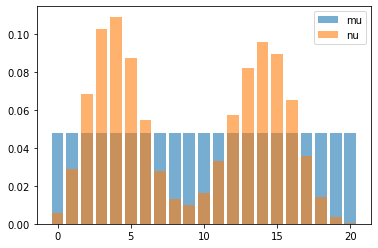

In [6]:
plt.bar(state_space, mu.pmf(state_space),
        label='mu', alpha=0.6)
plt.bar(state_space, nu.pmf(state_space),
        label='nu', alpha=0.6)
plt.legend()

In [7]:
pairs = [{'x': i, 'y': j} for i in state_space
                          for j in state_space]

## Helper function for plotting joint plots

In [8]:
def jplot(data):
    data = list(data)
    sns.jointplot(data=pd.DataFrame(data), x='x', y='y', kind='hist', 
            marginal_kws={'discrete': True},
            joint_kws={'discrete': True}
            )
    plt.show()

# Independent coupling

In [9]:
def q_independent(x,y):
    return mu.pmf(x) * nu.pmf(y)

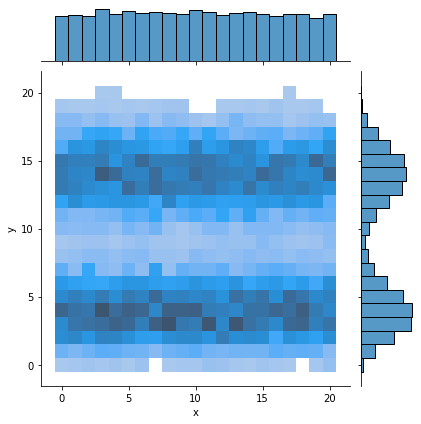

In [10]:
data = list(np.random.choice(pairs, 10000, 
            p=[q_independent(**pair) for pair in pairs]))
jplot(data)

# Optimal coupling from linear programming

state_space = [0,1,2,3]
mu = lambda x: [1/4, 1/4, 1/4, 1/4][x]
nu = lambda y: [1/8, 1/8, 0, 3/4][y]

In [11]:
cp.Problem
Q = cp.Variable((len(state_space), len(state_space)))

In [12]:
proba_constraints = [cp.sum(Q) == 1]\
                   +[Q >= 0]
marginals = [cp.sum(Q[:,j]) == nu.pmf(j) for j in state_space] \
           +[cp.sum(Q[i,:]) == mu.pmf(i) for i in state_space]

In [13]:
problem = cp.Problem(
        cp.Maximize(cp.sum(cp.diag(Q))),
        constraints=proba_constraints + marginals
        )
problem.solve()
# np.round(Q.value, 3)

0.6641521252440812

In [14]:
Q_value = Q.value.clip(0, None)
Q_value = Q_value/np.sum(Q_value)

In [15]:
np.sum(Q_value)

0.9999999999999999

In [16]:
def q_optimal(x,y):
    return Q_value[x,y]

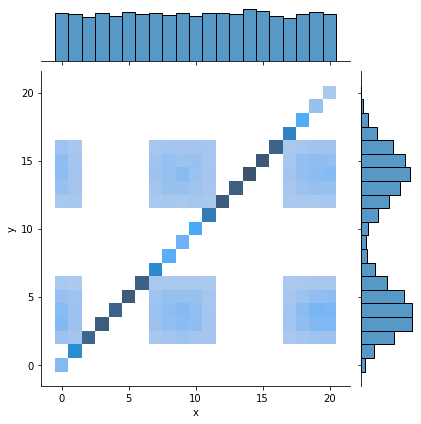

In [17]:
data = list(np.random.choice(pairs, 10000, 
            p=[q_optimal(**pair) for pair in pairs]))
jplot(data)

# Inverse CDF couling

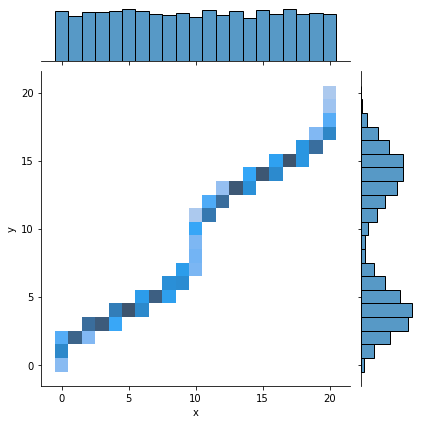

In [18]:
data = list([{'x': mu.ppf(U), 'y': nu.ppf(U)} 
            for U in np.random.uniform(size=10000)])
jplot(data)

# Reflection coupling

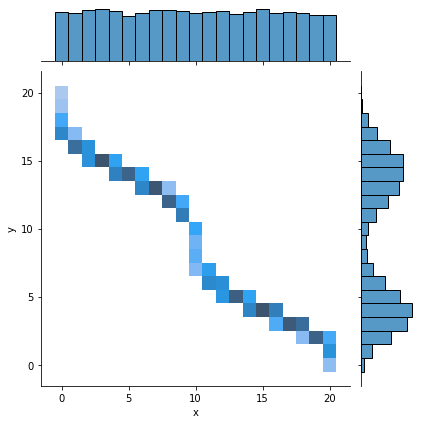

In [19]:
data = list([{'x': mu.ppf(U), 'y': nu.ppf(1-U)} 
            for U in np.random.uniform(size=10000)])
jplot(data)

# Optimal transport (Wasserstein-1) from linear programming

In [20]:
cp.Problem
Q = cp.Variable((len(state_space), len(state_space)))

In [21]:
proba_constraints = [cp.sum(Q) == 1]\
                   +[Q >= 0]
marginals = [cp.sum(Q[:,j]) == nu.pmf(j) for j in state_space] \
           +[cp.sum(Q[i,:]) == mu.pmf(i) for i in state_space]

In [22]:
problem = cp.Problem(
        cp.Minimize(cp.sum([Q[i,j]*abs(i-j)
                             for i in state_space
                             for j in state_space])),
        constraints=proba_constraints + marginals
        )
problem.solve()

1.3248694788553057

In [23]:
Q_value = Q.value.clip(0, None)
Q_value = Q_value/np.sum(Q_value)

In [24]:
np.sum(Q_value)

1.0

In [25]:
def q_wasserstein(x,y):
    return Q_value[x,y]

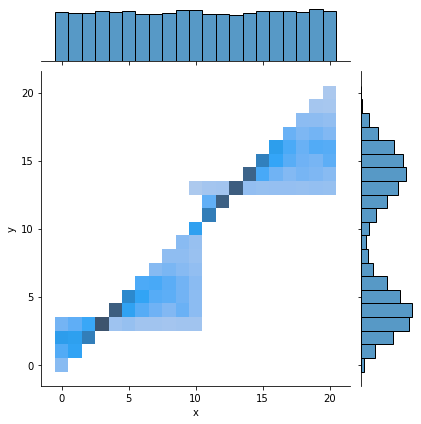

In [26]:
data = list(np.random.choice(pairs, 10000, 
            p=[q_wasserstein(**pair) for pair in pairs]))
jplot(data)

# Construction of the optimal coupling as a mixture

In [27]:
min_array = np.minimum(mu.pmf(state_space), 
               nu.pmf(state_space)) 
p = min_array.sum()
pi_pmf = (1/p) * min_array
pi = rv_discrete(values=(state_space, pi_pmf))

In [28]:
mu_tilde_pmf = (mu.pmf(state_space)-min_array)/(1-p)
mu_tilde = rv_discrete(values=(state_space, mu_tilde_pmf))

In [29]:
nu_tilde_pmf = (nu.pmf(state_space)-min_array)/(1-p)
nu_tilde = rv_discrete(values=(state_space, nu_tilde_pmf))

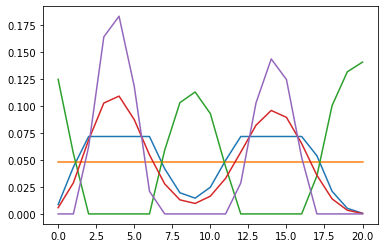

In [30]:
plt.plot(state_space, pi.pmf(state_space))
plt.plot(state_space, mu.pmf(state_space))
plt.plot(state_space, mu_tilde.pmf(state_space))
plt.plot(state_space, nu.pmf(state_space))
plt.plot(state_space, nu_tilde.pmf(state_space))

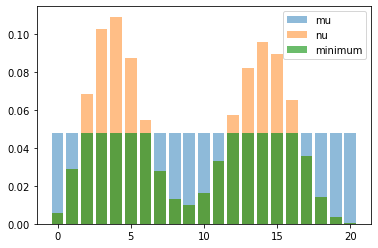

In [31]:
plt.bar(state_space, mu.pmf(state_space), label='mu', alpha=0.5)
plt.bar(state_space, nu.pmf(state_space), label='nu', alpha=0.5)
plt.bar(state_space, min_array, label='minimum', alpha=0.7)
plt.legend()

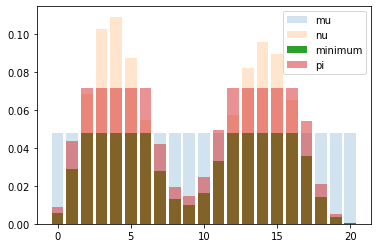

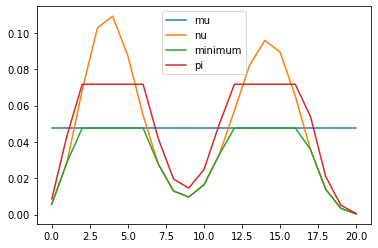

In [32]:
plt.bar(state_space, mu.pmf(state_space), label='mu', alpha=0.2)
plt.bar(state_space, nu.pmf(state_space), label='nu', alpha=0.2)
plt.bar(state_space, min_array, label='minimum', alpha=1.0)
plt.bar(state_space, pi.pmf(state_space), label='pi', alpha=0.5)
plt.legend()
plt.show()

plt.plot(state_space, mu.pmf(state_space), label='mu')
plt.plot(state_space, nu.pmf(state_space), label='nu')
plt.plot(state_space, min_array, label='minimum')
plt.plot(state_space, pi.pmf(state_space), label='pi')
plt.legend()
plt.show()

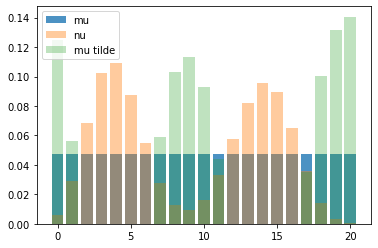

In [33]:
plt.bar(state_space, mu.pmf(state_space), label='mu', alpha=0.8)
plt.bar(state_space, nu.pmf(state_space), label='nu', alpha=0.4)
plt.bar(state_space, mu_tilde.pmf(state_space), label='mu tilde', alpha=0.3)
plt.legend()

Verification: curves should be indistinguishable if marginal for mu is correct

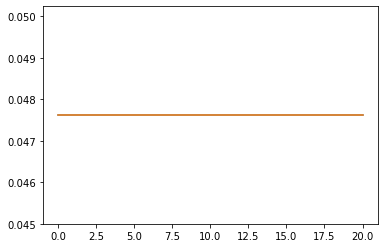

In [34]:
plt.plot(state_space, mu.pmf(state_space))
plt.plot(state_space, 
        p*pi.pmf(state_space) \
        + (1-p)*mu_tilde.pmf(state_space))

Verification: curves should be indistinguishable if marginal for nu is correct

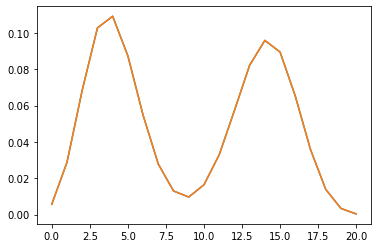

In [35]:
plt.plot(state_space, nu.pmf(state_space))
plt.plot(state_space, 
        p*pi.pmf(state_space) \
        + (1-p)*nu_tilde.pmf(state_space))

# Optimal coupling with conditional independence given $X\ne Y$

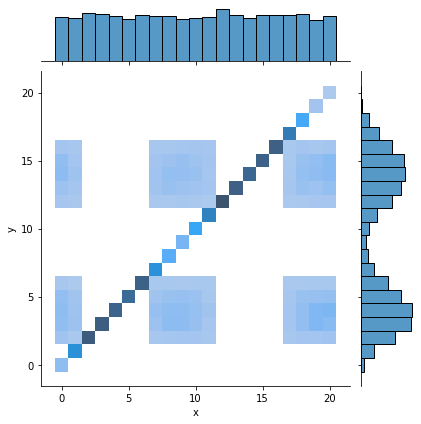

In [36]:
data = []
for _ in range(10000):
    B = np.random.binomial(1, p)
    U0 = np.random.uniform()
    U1 = np.random.uniform()
    U2 = np.random.uniform()
    Z = pi.ppf(U0)
    X_tilde = mu_tilde.ppf(U1)
    Y_tilde = nu_tilde.ppf(U2)
    data.append({'x': B*Z + (1-B)*X_tilde,
                 'y': B*Z + (1-B)*Y_tilde})
jplot(data)

# Optimal coupling with inverse CDF coupling conditionally given  $X\ne Y$

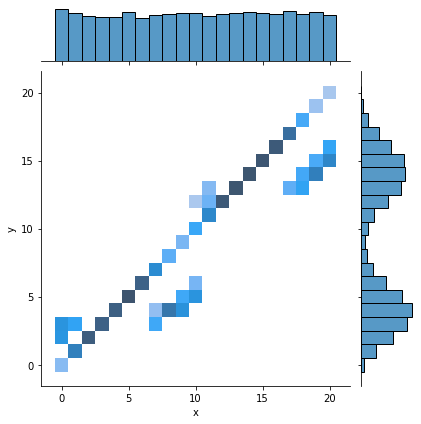

In [37]:
data = []
for _ in range(10000):
    B = np.random.binomial(1, p)
    U0 = np.random.uniform()
    U1 = np.random.uniform()
    Z = pi.ppf(U0)
    X_tilde = mu_tilde.ppf(U1)
    Y_tilde = nu_tilde.ppf(U1) # same as for X_tilde
    data.append({'x': B*Z + (1-B)*X_tilde,
                 'y': B*Z + (1-B)*Y_tilde})
jplot(data)

# Optimal coupling with reflection coupling conditionally given  $X\ne Y$

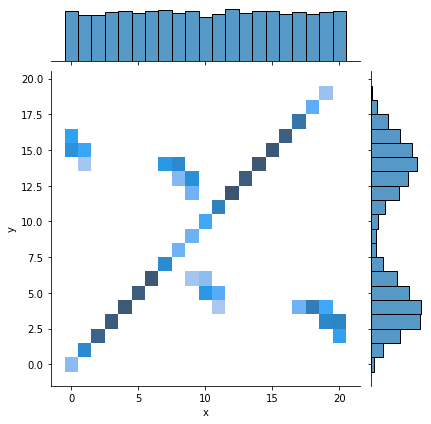

In [38]:
data = []
for _ in range(10000):
    B = np.random.binomial(1, p)
    U0 = np.random.uniform()
    U1 = np.random.uniform()
    Z = pi.ppf(U0)
    X_tilde = mu_tilde.ppf(U1)
    Y_tilde = nu_tilde.ppf(1-U1) # reflection using U1
    data.append({'x': B*Z + (1-B)*X_tilde,
                 'y': B*Z + (1-B)*Y_tilde})
jplot(data)